In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as cm
import pandas as pd
import seaborn as sns
import scipy.optimize as opt
import scipy.integrate as scint 

In [25]:
#read the experimental data from the csv file
p3_1 = pd.read_csv('../Data/3prime/3p1 raw.csv', header = None)
p3_3 = pd.read_csv('../Data/3prime/3p3 raw.csv', header = None)
p3_6 = pd.read_csv('../Data/3prime/3p6 raw.csv', header = None)

#read the positive control data from the csv file
FAM_decay = pd.read_csv('../Data/controls/FAM_decay.csv', header = None)

#read the initial signal data from the csv file
initial_signal = pd.read_csv('../Data/controls/initial_signal.csv')

#convert data to numpy arrays
p3_1 = np.array(p3_1)
p3_3 = np.array(p3_3)
p3_6 = np.array(p3_6)
FAM_decay = np.array(FAM_decay)
initial_signal = np.array(initial_signal)

In [26]:
#define the function for the system of ODEs
def TMSD_system(concs_init, t, k_eff):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param k_rep: reporter rate constant 
    :type k_rep: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I = concs_init[0]
    S = concs_init[1]
    SI = concs_init[2]
    O = concs_init[3]
    FQ = concs_init[4]
    OQ = concs_init[5]
    F = concs_init[6]
    
    k_rep = 10**4.142938439717612
    
    dI_dt = -k_eff*I*S
    dSI_dt = -dI_dt
    dS_dt = dI_dt
    
    dO_dt = k_eff*I*S - k_rep*O*FQ
    
    dOQ_dt = k_rep*O*FQ 
    dFQ_dt = - dOQ_dt 
    dF_dt = dOQ_dt
    
    return [dI_dt, dS_dt, dSI_dt, dO_dt, dFQ_dt, dOQ_dt, dF_dt]

#define the function which performs the integration of the system of ODEs
def solve_TMSD(t,k_eff,alpha):
    """DEFINE THE ODES WHICH DESCRIBE THE SYSTEM OF INTEREST
    :param concs_init: initial concentration of reactants and products
    :type concs_init: int, float
    :param t: time over which the experiment was performed
    :type t: array
    :param k_eff: effective rate constant
    :type k_eff: int, float
    :param k_rep: reporter rate constant 
    :type k_rep: int, float
    :return: ODEs for all of the reactants and products in the reaction"""
    I_init = alpha*60*10**-9
    S_init = alpha*60*10**-9 
    SI_init = 0 
    O_init = 0 
    FQ_init = alpha*60*10**-9
    OQ_init = 0 
    F_init = 0 
    
    concs_init = [I_init, S_init, SI_init, O_init, FQ_init, OQ_init, F_init]

    
    soln = scint.odeint(TMSD_system,concs_init,t, args=(10**k_eff,), hmax = 20)
    return soln[:,-1]/(60*10**-9)

#define the function which fits the integral to the experimental data
def fit_TMSD(t,F):
    """FITS SOLUTION OF NUMERICAL INTEGRATION TO EXPERIMENTAL DATA
    :param t: time over which the experiment was performed
    :type t: array
    :param F: initial concentration of the single fluorescently-labelled strand
    :type F: int, float
    :return: optimal estimates for the parameters and the covariance associated with these estimates"""
    #popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,4.5,0.8], bounds=([1., 4., 0],[7.,5., 1.]))   
    popt, pcov = opt.curve_fit(solve_TMSD,t,F,p0=[6,0.8], bounds=([1., 0.],[8., 1.]))   
    return popt, pcov

keff =  7.9999999999715845
alpha =  0.2374719300028004
[[ 4.27367740e+00 -5.47642228e-04]
 [-5.47642228e-04  2.83012542e-07]]
[2.06728745e+00 5.31989231e-04]
keff =  4.673593090812976
alpha =  0.509282688073623
[[ 4.43584072e-05 -6.76487555e-06]
 [-6.76487555e-06  1.08291731e-06]]
[0.00666021 0.00104063]
keff =  5.903213745778755
alpha =  0.775764380313523
[[ 2.69162920e-06 -7.28702260e-08]
 [-7.28702260e-08  2.87707738e-09]]
[1.64061854e-03 5.36383947e-05]


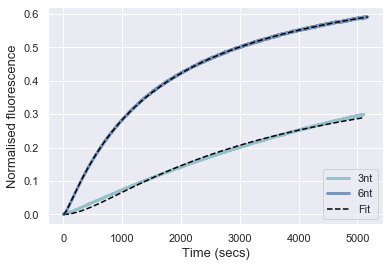

In [27]:
#############START FROM THE FIRST FLUORESCENCE SIGNAL#############
#average across the three replicates
sns.set()
plt.figure()
color=sns.cubehelix_palette(start = 0.6, rot=-.5)
labels = ['1nt', '3nt', '6nt']
toehold_lengths = [p3_1, p3_3, p3_6]
#loop through the TMSD experiments
for ind, th_len in enumerate(toehold_lengths):
    
    #establish empty matrices for time, the initial signal, and the fluorescence over time
    time = np.empty((len(th_len[:, 0]), 3))
    fluor = np.empty((len(th_len[:, 0]), 3))
    
    #fill the matrices the with the data for the TMSD experiments
    time[:, ind] = th_len[:,0]
    fluor[:, ind] = th_len[:,1:].mean(axis = 1)
    
    
    FAM_decay_time = FAM_decay[:, 0].tolist()
    time_time = time[:, ind].tolist()
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    if FAM_decay[0, 0] <= time[0, ind]:     
        start_time = FAM_decay_time.index(time[0, ind])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]), 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = np.divide((np.subtract(fluor[:, ind], fluor[0, ind])),(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[0, ind])))
            time_molar = np.subtract(time[:, ind], time[0, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]) - start_time, 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[:end_time+1, ind], fluor[0, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[0, ind]))
            time_molar = np.subtract(time[:end_time + 1, ind], time[0, ind])
    #set the start time to the time at which experiment of interest starts or the positive control experiment starts (whichever starts later)
    else: 
        start_time = time_time.index(FAM_decay[0, 0])
        #set the end time to the time at which the experiment of interest ends or the positive control experiment ends (whichever ends earlier)
        if FAM_decay[-1, 0] >= time[-1, ind]:
            molar_fluor = np.empty((len(th_len[:, 0]) - start_time, 3))
            end_time = FAM_decay_time.index(time[-1, ind])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:end_time+1, 1], fluor[start_time, ind]))
            time_molar = np.subtract(time[start_time:, ind], time[start_time, ind])
        else:
            molar_fluor = np.empty((len(FAM_decay[:, 0]), 3))
            end_time = time_time.index(FAM_decay[-1, 0])
            molar_fluor[:, ind] = (np.subtract(fluor[start_time:end_time+1, ind], fluor[start_time, ind]))/(np.subtract(FAM_decay[start_time:, 1], fluor[start_time, ind])) 
            time_molar = np.subtract(time[start_time:end_time+1, ind], time[start_time, ind])
    
    #fit the experimental data to the bimolecular model using numerical integration 
    popt, pcov = fit_TMSD(time_molar, molar_fluor[:, ind])
    print('keff = ', popt[0])
    print('alpha = ', popt[1])
    print(pcov)
    #determine one standard deviation errors for the parameters 
    perr = np.sqrt(np.diag(pcov))
    print(perr)
    TMSD_sol = solve_TMSD(time_molar, *popt)
    
    #plot the numerical integration and the fits
    if ind in range(1, 3):
        plt.plot(time_molar, molar_fluor[:, ind], color = color [ind], linewidth = 3, label = labels[ind])
        if ind == 1:
            plt.plot(time_molar, TMSD_sol, '--', c = 'black', label = 'Fit')
        else: 
            plt.plot(time_molar, TMSD_sol, '--', c = 'black')
ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[2], handles[1]]
labels = [labels[0], labels[2], labels[1]]

ax.legend(handles,labels,loc='lower right')

plt.xlabel('Time (secs)',  fontsize = 13, fontname = 'Arial')   
plt.ylabel('Normalised fluorescence',  fontsize = 13, fontname = 'Arial')
plt.savefig('3prime keff.svg')
plt.show()